### Machine Learning for AES
We will be experimenting with different machine learning based models for essay scoring. They will be trained on style and content based features. The goal is to improve the mean quadratic kappa score. 

In [1]:
from requirements_base import *
#Feature Extraction
from requirements_feature import *
#Keys
from requirements_key import *
#Data Frame 
from requirements_frame import *
#Traing 
from requirements_trainer import *

%matplotlib inline

unable to import 'smart_open.gcs', disabling that module


# 1. Dataset Processing
We will first load the essays from the csv filed provided in the asap data set. These essays will then be divided based on their set no and stored in separate data frames. We will also load the prompt text that is divided in to 4 paragraphs for the source dependent essays. This will be used to generate similarity scores for the essays. 

In [2]:
dataset_path = "../asap-aes/training_set_rel3.tsv"
data = pd.read_csv(dataset_path, sep="\t", encoding="ISO-8859-1", index_col="essay_id")

min_scores = [2, 1, 0, 0, 0, 0, 0, 0]
max_scores = [12, 6, 3, 3, 4, 4, 30, 60]

essay_sets, data_min_scores, data_max_scores = split_in_sets(data, min_scores, max_scores)
set1, set2, set3, set4, set5, set6, set7, set8 = tuple(essay_sets)
data.dropna(axis=1, inplace=True)

data.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
print("All Data:", len(data))
data.head()

Set	Count	Attributes	Score Range	Grade	Type
1	1783	5		[2,12]		8th	PNR
2	1800	8		[1,6]		10th	PNR
3	1726	5		[0,3]		10th	SDR
4	1770	5		[0,3]		10th	SDR
5	1805	5		[0,4]		8th	SDR
6	1800	5		[0,4]		10th	SDR
7	1569	13		[0,30]		7th	PNR
8	723	17		[0,60]		10th	PNR

PNR: Persuasive / Narrative  / Expository 	 SDR: Source Dependent Responses
All Data: 12976


essay_set                                              essay  \
essay_id                                                                 
1                 1  Dear local newspaper, I think effects computer...   
2                 1  Dear @CAPS1 @CAPS2, I believe that using compu...   
3                 1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
4                 1  Dear Local Newspaper, @CAPS1 I have found that...   
5                 1  Dear @LOCATION1, I know having computers has a...   

          domain1_score  
essay_id                 
1                     8  
2                     9  
3                     7  
4                    10  
5                     8

### Feature Generation Example
Here is an example of features generated for the first essay from the dataset.

In [3]:
pp = pprint.PrettyPrinter(indent=4)

#Featrues
first_essay = data.iloc[0][essay_key]
print(first_essay)
start = time()
_, _, features, extra_features = essay_to_sentences(first_essay, set_no = 1)
end = time()

print("\nExecution time:", end-start)

print("\n\nFeatures: ")
pp.pprint(features)

print("\n\n Extra Features: ")
pp.pprint(extra_features)



Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the economy

### Generation of Learning Data
We will now process the essays one by one and generate the style based features for them. We will also be generating word count vector based similarities with the prompt for the source dependent essays. The dimansionality of these word count vectors is reduced using LSA.

In [4]:
start = time()
X, y = makeDataFrame(data)
end = time()
X_basic = X[feature_keys_list]

print("\nExecution time to make dataframe ", (end-start)/60, " mins\n")

print("All Features:\n")
display(X.head(1))

print("Basic 11 Features:\n")
display(X_basic.head(1))

Generating Style Features
Processed  3000  essays of 12976
Processed  6000  essays of 12976
Processed  9000  essays of 12976
Processed  12000  essays of 12976
Generating Similarity Measures
Processed  3000  essays of 12976
Processed  6000  essays of 12976
Processed  9000  essays of 12976
Processed  12000  essays of 12976

Execution time to make dataframe  4.494673852125803  mins

All Features:



char_count  word_count  diff_words_count  word_count_root  sen_count  \
1        1478         350               164         4.325308         16   

   avg_word_len  avg_sen_len  l5_word_count  l6_word_count  l7_word_count  \
1      4.222857       21.875             74             59             34   

   ...  adverbs_count  nouns_count  adjective_count  \
1  ...             21           84               22   

                                           sentences  word_count_vector  \
1  [dear, local, newspaper, i, think, effects, co...                NaN   

   para_1_sim  para_2_sim  para_3_sim  para_4_sim whole_prompt_sim  
1         NaN         NaN         NaN         NaN              NaN  

[1 rows x 26 columns]

Basic 11 Features:



char_count  word_count  diff_words_count  word_count_root  sen_count  \
1        1478         350               164         4.325308         16   

   avg_word_len  avg_sen_len  l5_word_count  l6_word_count  l7_word_count  \
1      4.222857       21.875             74             59             34   

   l8_word_count                                          sentences  \
1             13  [dear, local, newspaper, i, think, effects, co...   

  word_count_vector  
1               NaN

### Splitting by set number
The main dataframe will be split based on the set number of the essay.

In [5]:
X_sets = []
y_sets = []
essay_sets = [set1, set2, set3, set4, set5, set6, set7, set8]
for set_no in range(8):
    X_set, y_set = X.loc[X.index & essay_sets[set_no].index], y.loc[y.index & essay_sets[set_no].index]
    X_sets.append(X_set)
    y_sets.append(y_set) 

    print("Set", (set_no+1), ":", len(X_set), " essays")   
    display(X_set.head(1))

Set 1 : 1783  essays


char_count  word_count  diff_words_count  word_count_root  sen_count  \
1        1478         350               164         4.325308         16   

   avg_word_len  avg_sen_len  l5_word_count  l6_word_count  l7_word_count  \
1      4.222857       21.875             74             59             34   

   ...  adverbs_count  nouns_count  adjective_count  \
1  ...             21           84               22   

                                           sentences  word_count_vector  \
1  [dear, local, newspaper, i, think, effects, co...                NaN   

   para_1_sim  para_2_sim  para_3_sim  para_4_sim whole_prompt_sim  
1         NaN         NaN         NaN         NaN              NaN  

[1 rows x 26 columns]

Set 2 : 1800  essays


char_count  word_count  diff_words_count  word_count_root  sen_count  \
2978        2064         486               194         4.695254         19   

      avg_word_len  avg_sen_len  l5_word_count  l6_word_count  l7_word_count  \
2978      4.246914    25.578947            114             57             32   

      ...  adverbs_count  nouns_count  adjective_count  \
2978  ...             36          130               30   

                                              sentences  word_count_vector  \
2978  [certain, materials, being, removed, from, lib...                NaN   

      para_1_sim  para_2_sim  para_3_sim  para_4_sim whole_prompt_sim  
2978         NaN         NaN         NaN         NaN              NaN  

[1 rows x 26 columns]

Set 3 : 1726  essays


char_count  word_count  diff_words_count  word_count_root  sen_count  \
5978         209          51                31         2.672345          3   

      avg_word_len  avg_sen_len  l5_word_count  l6_word_count  l7_word_count  \
5978      4.098039         17.0             13             10              4   

      ...  adverbs_count  nouns_count  adjective_count  \
5978  ...              0           15                1   

                                              sentences  \
5978  [the, features, of, the, setting, affect, the,...   

                                      word_count_vector  para_1_sim  \
5978  [8.0, 2.0, 4.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, ...    0.607915   

      para_2_sim  para_3_sim  para_4_sim whole_prompt_sim  
5978    0.547689    0.497195    0.425263         0.591386  

[1 rows x 26 columns]

Set 4 : 1770  essays


char_count  word_count  diff_words_count  word_count_root  sen_count  \
8863         243          58                44         2.759669          3   

      avg_word_len  avg_sen_len  l5_word_count  l6_word_count  l7_word_count  \
8863      4.189655    19.333333             16              8              4   

      ...  adverbs_count  nouns_count  adjective_count  \
8863  ...              4           10                3   

                                              sentences  \
8863  [the, author, concludes, the, story, with, thi...   

                                      word_count_vector  para_1_sim  \
8863  [4.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, ...    0.385886   

      para_2_sim  para_3_sim  para_4_sim whole_prompt_sim  
8863    0.430285    0.474141    0.473287         0.496734  

[1 rows x 26 columns]

Set 5 : 1805  essays


char_count  word_count  diff_words_count  word_count_root  sen_count  \
11827         570         131                80         3.383123          8   

       avg_word_len  avg_sen_len  l5_word_count  l6_word_count  l7_word_count  \
11827      4.351145       16.375             36             21              9   

       ...  adverbs_count  nouns_count  adjective_count  \
11827  ...              3           37                5   

                                               sentences  \
11827  [in, this, memoir, of, narciso, rodriguez, per...   

                                       word_count_vector  para_1_sim  \
11827  [4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 4.0, ...    0.492161   

       para_2_sim  para_3_sim  para_4_sim whole_prompt_sim  
11827    0.424351    0.513145    0.398284         0.565892  

[1 rows x 26 columns]

Set 6 : 1800  essays


char_count  word_count  diff_words_count  word_count_root  sen_count  \
14834         560         123                88         3.330246          6   

       avg_word_len  avg_sen_len  l5_word_count  l6_word_count  l7_word_count  \
14834      4.552846         20.5             34             25             17   

       ...  adverbs_count  nouns_count  adjective_count  \
14834  ...              7           35               11   

                                               sentences  \
14834  [there, were, many, obstacles, that, the, buil...   

                                       word_count_vector  para_1_sim  \
14834  [1.0, 1.0, 2.0, 2.0, 1.0, 14.0, 1.0, 2.0, 4.0,...    0.642754   

       para_2_sim  para_3_sim  para_4_sim whole_prompt_sim  
14834     0.75521    0.732777    0.786687         0.786668  

[1 rows x 26 columns]

Set 7 : 1569  essays


char_count  word_count  diff_words_count  word_count_root  sen_count  \
17834         382          94                57         3.113737          3   

       avg_word_len  avg_sen_len  l5_word_count  l6_word_count  l7_word_count  \
17834       4.06383    31.333333             24             18             12   

       ...  adverbs_count  nouns_count  adjective_count  \
17834  ...              4           25                2   

                                               sentences  word_count_vector  \
17834  [patience, is, when, your, waiting, i, was, pa...                NaN   

       para_1_sim  para_2_sim  para_3_sim  para_4_sim whole_prompt_sim  
17834         NaN         NaN         NaN         NaN              NaN  

[1 rows x 26 columns]

Set 8 : 723  essays


char_count  word_count  diff_words_count  word_count_root  sen_count  \
20716        2562         708               239          5.15832         39   

       avg_word_len  avg_sen_len  l5_word_count  l6_word_count  l7_word_count  \
20716      3.618644    18.153846            104             52             22   

       ...  adverbs_count  nouns_count  adjective_count  \
20716  ...             29          178               41   

                                               sentences  word_count_vector  \
20716  [a, long, time, ago, when, i, was, in, third, ...                NaN   

       para_1_sim  para_2_sim  para_3_sim  para_4_sim whole_prompt_sim  
20716         NaN         NaN         NaN         NaN              NaN  

[1 rows x 26 columns]

# 2. Training
We will be splitting the data in to 5 folds and evaluating the mean quadratic kappa score on those 5 folds.

### Testing performance of various classifiers
We will be testing how Regression, KNN and SVM perform on the different sets. We will be first using the 11 basic features. We will then be using all the 19 features. These are style based features.

In [6]:
# Training on individual dataset
for classifier in get_all_classifiers():
    print("Basic 11 features ( Model: ", type(classifier).__name__, ")")
    for set_no in range(8):
        np.random.seed(1)
        X_basic_set, y_set = X_sets[set_no][feature_keys_list], y_sets[set_no]
        print("Mean Quadratic Kappa Score - Set", (set_no+1), ":", evaluate(X_basic_set, y_set, None, classifier)[0])
    print()

Basic 11 features ( Model:  LinearRegression )
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 1 : 0.8388
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6912
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6438
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 4 : 0.6888
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7777
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 6 : 0.6626
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 7 : 0.7303
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 8 : 0.7241

Basic 11 features ( Model:  SVC )
[ 0.34  mins ] Mean Quadratic Kappa Score - Set 1 : 0.7972
[ 0.89  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6412
[ 0.104  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6937
[ 0.266  mins ] Mean Quadratic Kappa Score - Set 4 : 0.6737
[ 0.033  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7889
[ 0.183  mins ] Mean Quadratic Kappa Score - Set 6 : 0.6117
[ 0.864  mins ] Mean Quadratic Kappa Score - Set 7 : 0.6762
[ 2.186  mins ] Mean

In [7]:
for classifier in get_all_classifiers():
    print("All features ( Model: ", type(classifier).__name__, ")")
    for set_no in range(8):
        np.random.seed(1)
        X_set, y_set = X_sets[set_no], y_sets[set_no]
        print("Mean Quadratic Kappa Score - Set", (set_no+1), ":", evaluate(X_set, y_set, None, classifier)[0])
    print()

All features ( Model:  LinearRegression )
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 1 : 0.8422
[ 0.0  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6977
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6458
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 4 : 0.688
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7753
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 6 : 0.6778
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 7 : 0.7703
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 8 : 0.7266

All features ( Model:  SVC )
[ 0.389  mins ] Mean Quadratic Kappa Score - Set 1 : 0.8087
[ 0.715  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6697
[ 0.129  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6874
[ 0.292  mins ] Mean Quadratic Kappa Score - Set 4 : 0.6601
[ 0.055  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7819
[ 0.142  mins ] Mean Quadratic Kappa Score - Set 6 : 0.6591
[ 0.848  mins ] Mean Quadratic Kappa Score - Set 7 : 0.7319
[ 1.545  mins ] Mean Quadratic 

### Hyper parameter tuning
We tried different hyper parameters for SVM and KNN. But none of them produced results that were better than regression.

In [8]:
print("Parameter tuning for SVM - Set 1")
Cs = [0.025, 0.05, 0.1, 0.5, 0.9]
for C in Cs:
    svm = SVC(kernel="linear", C=C)
    np.random.seed(1)
    k, _ = evaluate(X_sets[0], y_sets[0], None, svm)
    print("C:", C, " Mean Quadratic Kappa Score:", k)
print()

print("Paramter tuning for KNN - Set 1")
NNs = [10, 15, 25, 30]
for nn in NNs:
    knn = KNeighborsClassifier(nn)
    np.random.seed(1)
    k, _ = evaluate(X_sets[0], y_sets[0], None, knn)
    print("NN:", nn, " Mean Quadratic Kappa Score:", k)
print()

Parameter tuning for SVM - Set 1
[ 0.349  mins ] C: 0.025  Mean Quadratic Kappa Score: 0.8087
[ 0.608  mins ] C: 0.05  Mean Quadratic Kappa Score: 0.8085
[ 1.084  mins ] C: 0.1  Mean Quadratic Kappa Score: 0.8091
[ 3.55  mins ] C: 0.5  Mean Quadratic Kappa Score: 0.8067
[ 4.91  mins ] C: 0.9  Mean Quadratic Kappa Score: 0.8121

Paramter tuning for KNN - Set 1
[ 0.002  mins ] NN: 10  Mean Quadratic Kappa Score: 0.787
[ 0.002  mins ] NN: 15  Mean Quadratic Kappa Score: 0.79
[ 0.002  mins ] NN: 25  Mean Quadratic Kappa Score: 0.7959
[ 0.002  mins ] NN: 30  Mean Quadratic Kappa Score: 0.7945



### Evaluation using whole dataset
After testing out different models, we decided to go ahead with linear regression. We trained linear regression with
the 11 basic features and then used all the 19 features. These are all style based features.

In [9]:
print("Evaluation using basic 11 features (All Essays)")

classifier = LinearRegression()
np.random.seed(1)
print("Model:", type(classifier).__name__)
k, _ = evaluate(X_basic, y, None, classifier)
print("Mean Quadratic Kappa Score:", k)
print()

print("Evaluation using all features (All Essays)")
classifier = LinearRegression()
np.random.seed(1)
print("Model:", type(classifier).__name__)
k, _ = evaluate(X, y, None, classifier)
print("Mean Quadratic Kappa Score:", k)
print()

Evaluation using basic 11 features (All Essays)
Model: LinearRegression
[ 0.002  mins ] Mean Quadratic Kappa Score: 0.747

Evaluation using all features (All Essays)
Model: LinearRegression
[ 0.001  mins ] Mean Quadratic Kappa Score: 0.8221



### Feature performance testing
We next check how the model performs when trained on an individual feature. This gives us an idea of how critical the features are. We then plot the top 4 performing features to see how the essay scores are distributed w.r.t to these features.

[ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] 
('punctuations_count', 0.5507)
('sen_count', 0.531)
('adverbs_count', 0.518)
('stopwords_count', 0.513)
('word_count', 0.5116)
('diff_words_count', 0.5029)
('adjective_count', 0.4709)
('char_count', 0.4513)
('word_count_root', 0.4462)
('nouns_count', 0.4457)
('l5_word_count', 0.3274)
('verbs_count', 0.29)
('l6_word_count', 0.2553)
('avg_word_len', 0.2449)
('small_sentence_count', 0.215)
('l7_word_count', 0.164)
('l8_word_count', 0.0696)
('spelling_error_count', 0.0137)
('avg_sen_len', 0.0084)


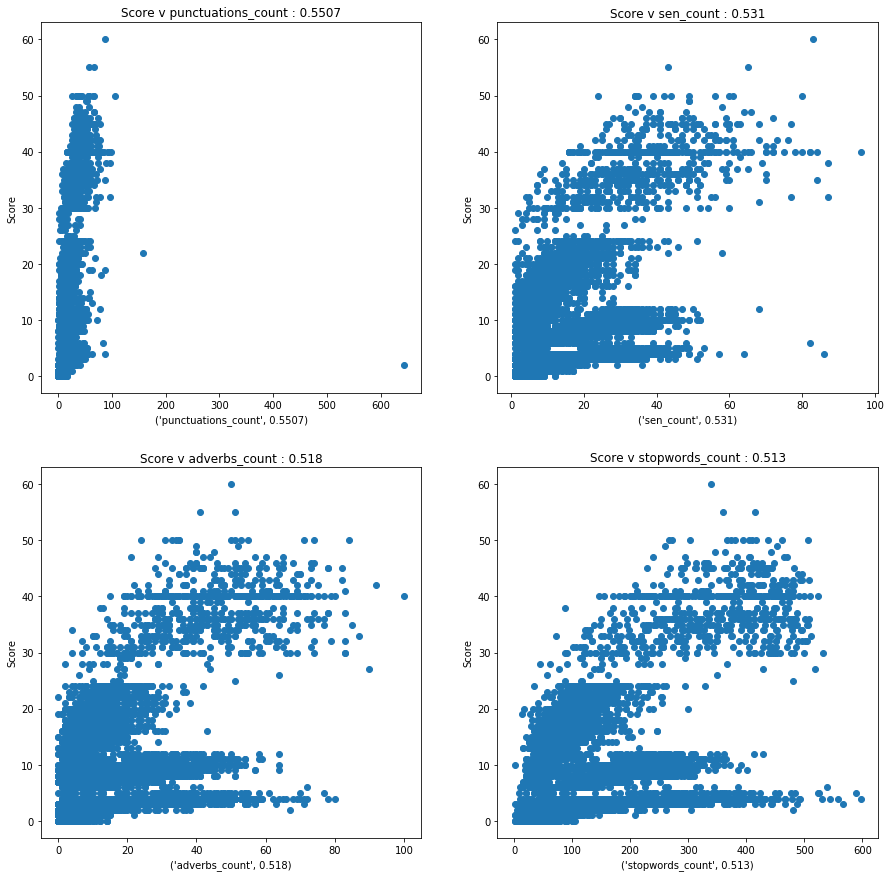

In [10]:
feature_kapps = []
for feature in all_feature_keys_list:
    if feature == sentences_key or feature == word_count_vector_key:
        continue
    np.random.seed(1)
    k_feat, _ = evaluate(X[[feature]+[sentences_key]], y)
    feature_kapps.append((feature, k_feat))
print()
feature_kapps.sort(key = lambda x:  -x[1])
for feature_kappa in feature_kapps:
    print(feature_kappa)
    

top_features = feature_kapps[:4]
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
axs = [ax1, ax2, ax3, ax4]
for i in range(len(top_features)):
    ax = axs[i]
    top_feature = top_features[i]
    ax.scatter(X[[top_feature[0]]],y)
    ax.set_ylabel('Score')
    ax.set_xlabel(top_feature)
    ax.set_title("Score v " + top_feature[0] + " : " + str(top_feature[1]))

fig.savefig('../figs/ScoreVFeature.png', bbox_inches = "tight")

# 3. Content based features
Next we explored the addition of content based features using word2vec and similarity measures. Word2vec model was trained on the data and then used to get an average vector representation for each essay. Similarity measures were generated using 2 approaches. First we used LSA to calculate similairty between word vector representations of essays and paras of the required readings from their question prompts. We also computed the average word vectors for these paras and calculated thier similarity with the word vector representations of the prompts.

In [11]:
print("Evaluation using all features (All Essays)")

np.random.seed(1)
classifier = LinearRegression()
print("Model:", type(classifier).__name__)
k, _ = evaluate(X, y, None, classifier, wordvec=True)
print("Mean Quadratic Kappa Score:", k)
print()

Evaluation using all features (All Essays)
Model: LinearRegression
[ 3.557  mins ] Mean Quadratic Kappa Score: 0.9322



We also tuned the parameter of word vector size when evaluating on individual sets and a lower value seemed to work better. This is most likely because there were lesser learning examples and in this case having a lower dimensionality of the training data helps. Also lower value for minimum word count when generating word vectors also gave better results. The main reason for this is the smaller legnth of essays.

In [12]:
for vec_size in [300, 100, 50, 30]:
    print("Number of features:", vec_size)
    for set_no in range(8):
        np.random.seed(1)
        X_set, y_set = X_sets[set_no], y_sets[set_no]
        classifier = LinearRegression()
        k, _ = evaluate(X_set, y_set, None, classifier, wordvec=True, wv_size=vec_size)
        print("Mean Quadratic Kappa Score - Set", (set_no+1), ":", k)
    print()

Number of features: 300
[ 0.573  mins ] Mean Quadratic Kappa Score - Set 1 : 0.8106
[ 0.613  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6519
[ 0.345  mins ] Mean Quadratic Kappa Score - Set 3 : 0.5736
[ 0.308  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7533
[ 0.351  mins ] Mean Quadratic Kappa Score - Set 5 : 0.785
[ 0.369  mins ] Mean Quadratic Kappa Score - Set 6 : 0.7759
[ 0.343  mins ] Mean Quadratic Kappa Score - Set 7 : 0.7498
[ 0.414  mins ] Mean Quadratic Kappa Score - Set 8 : 0.5327

Number of features: 100
[ 0.528  mins ] Mean Quadratic Kappa Score - Set 1 : 0.8405
[ 0.557  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6797
[ 0.215  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6249
[ 0.195  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7527
[ 0.238  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7853
[ 0.278  mins ] Mean Quadratic Kappa Score - Set 6 : 0.7716
[ 0.252  mins ] Mean Quadratic Kappa Score - Set 7 : 0.7948
[ 0.327  mins ] Mean Quadratic Kappa Score - Set 8 :

In [13]:
for min_count in [5, 10, 20, 30]:
    print("Min count:", min_count)
    for set_no in range(8):
        np.random.seed(1)
        X_set, y_set = X_sets[set_no], y_sets[set_no]
        classifier = LinearRegression()
        k, _ = evaluate(X_set, y_set, None, classifier, wordvec=True, wv_size=50,  min_count=min_count)
        print("Mean Quadratic Kappa Score - Set", (set_no+1), ":", k)
    print()

Min count: 5
[ 0.509  mins ] Mean Quadratic Kappa Score - Set 1 : 0.8442
[ 0.51  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6906
[ 0.186  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6315
[ 0.17  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7486
[ 0.203  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7929
[ 0.243  mins ] Mean Quadratic Kappa Score - Set 6 : 0.7868
[ 0.23  mins ] Mean Quadratic Kappa Score - Set 7 : 0.8022
[ 0.329  mins ] Mean Quadratic Kappa Score - Set 8 : 0.7134

Min count: 10
[ 0.472  mins ] Mean Quadratic Kappa Score - Set 1 : 0.842
[ 0.474  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6967
[ 0.169  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6256
[ 0.161  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7522
[ 0.192  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7916
[ 0.247  mins ] Mean Quadratic Kappa Score - Set 6 : 0.7765
[ 0.219  mins ] Mean Quadratic Kappa Score - Set 7 : 0.8035
[ 0.296  mins ] Mean Quadratic Kappa Score - Set 8 : 0.7132

Min count: 20
[

Next we tested the performance after using average word2vec representation and prompt similarity using LSA and word2vec.

In [14]:
for set_no in range(4):
    np.random.seed(1)
    X_set, y_set = X_sets[set_no+2], y_sets[set_no+2]  
    classifier = LinearRegression()
    k, _ = evaluate(X_set, y_set, data, classifier, wordvec=True, wv_size=50, min_count=10, lsa=True, wordvec_sim=True)
    print("Mean Quadratic Kappa Score - Set", (set_no+3), ":", k)
print()

[ 2.097  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6346
[ 2.181  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7484
[ 1.66  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7936
[ 2.882  mins ] Mean Quadratic Kappa Score - Set 6 : 0.7885



### Source dependent essay comparison
We evaluated the performance of the model on all the source dependent essays using only style based features and then along with the content based features.

In [15]:
X_src_dep_frames = [X_sets[2], X_sets[3], X_sets[4], X_sets[5]]
y_src_dep_frames = [y_sets[2], y_sets[3], y_sets[4], y_sets[5]]
X_src_dep = pd.concat(X_src_dep_frames)
y_src_dep = pd.concat(y_src_dep_frames)

np.random.seed(1)
classifier = LinearRegression()
k, _ = evaluate(X_src_dep, y_src_dep, data, classifier, wordvec=True, wv_size=50, min_count=10, lsa=True, wordvec_sim=True)
print("Mean Quadratic Kappa Score (All Source Dependent):", k)

np.random.seed(1)
classifier = LinearRegression()
k, _ = evaluate(X_src_dep, y_src_dep, None, classifier)
print("Mean Quadratic Kappa Score (All Source Dependent - No Similarity):", k)

[ 9.989  mins ] Mean Quadratic Kappa Score (All Source Dependent): 0.7976
[ 0.003  mins ] Mean Quadratic Kappa Score (All Source Dependent - No Similarity): 0.7569


What we realized is that the sets 3 and 4 had a low range of grading scores (0 - 3). This was affecting their performance as in this lower range the corellation could be thrown off even if the rating was a little different. So we decided to try using random forest classifer on these sets to see if the performance improved. The idea was that random forest classifier is able to give us a more tighter fit than regression. We used all the 3 content based features 1) Average word2vec, 2) LSA similarity, 3) Average word2vec similarity. 
Random forest helped improve the performance for set 3 but not so much for set 4. Hence we decided to explore the reason behind this. When you see the distribution of scores alloted to different teams, for set 3 the scores are quite skewed. We suspect that this is the reason why regression was producing lower mean quadratic kappa score. For set 4, where the scores are more evenly distributed, we didn't notice any performance improvement.

In [16]:
for set_no in range(2):
    np.random.seed(1)
    X_set, y_set = X_sets[set_no+2], y_sets[set_no+2]
    classifier = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=5, random_state=1)
    k, _ = evaluate(X_set, y_set, data, classifier, wordvec=True, wv_size=50, min_count=10, lsa=True, wordvec_sim=True)
    print("Mean Quadratic Kappa Score - Set", (set_no+3), ":", k)
print()

[ 2.475  mins ] Mean Quadratic Kappa Score - Set 3 : 0.7002
[ 2.68  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7379



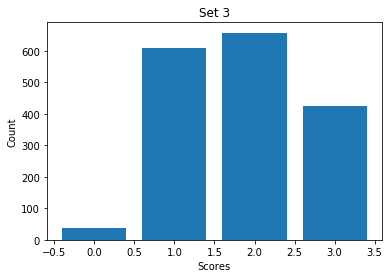

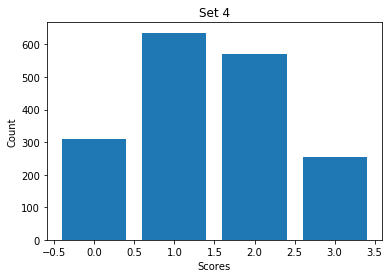

In [17]:
def analyze_score_distribution(scores, set_no):
    fig = plt.figure()
    scores = scores.values.reshape(-1)
    u_scores = dict(zip(list(scores),[list(scores).count(i) for i in list(scores)]))
    u_scores = [u_scores[0], u_scores[1], u_scores[2], u_scores[3]]
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.title("Set "+str(set_no))
    plt.bar([0, 1, 2, 3], u_scores)

analyze_score_distribution(y_sets[2], set_no=3)

analyze_score_distribution(y_sets[3], set_no=4)

In [18]:
for set_no in range(8):
    np.random.seed(1)
    X_set, y_set = X_sets[set_no], y_sets[set_no]
    classifier = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=5, random_state=1)
    k, _ = evaluate(X_set, y_set, None, classifier, wordvec=True, wv_size=50, min_count=10)
    print("Mean Quadratic Kappa Score - Set", (set_no+1), ":", k)
print()

[ 0.805  mins ] Mean Quadratic Kappa Score - Set 1 : 0.8125
[ 0.775  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6734
[ 0.4  mins ] Mean Quadratic Kappa Score - Set 3 : 0.7019
[ 0.45  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7415
[ 0.429  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7973
[ 0.492  mins ] Mean Quadratic Kappa Score - Set 6 : 0.7303
[ 0.527  mins ] Mean Quadratic Kappa Score - Set 7 : 0.7279
[ 0.47  mins ] Mean Quadratic Kappa Score - Set 8 : 0.5508

